### Facial Expression Recognition with ANN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

The 'get_face_Data' function balances the under-represented data in class 1 (Disgust) by repeating the data.

In [2]:
from process import get_face_Data, one_hot_encoder
from numpyam import classification_rate

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
sent_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [5]:
Xdat, Ydat = get_face_Data()
X_train, X_test, Y_train, Y_test = train_test_split(Xdat, Ydat, test_size = 2000)
T_train, _ = one_hot_encoder(Y_train)
T_test, _ =  one_hot_encoder(Y_test)

In [6]:
full_iter = 150 # number of iterations over the entire data while training
eta = 0.00005 #learning rate
alpha = 0.01 # regularization
bat = 500 # batch size

#### ANN with 2 hidden layers

In [7]:
# network size and structure
M1 = 50
M2 = 50
K = len(set(Ydat)) # = 7
N, D = X_train.shape # D = 48*48

n_bat = N // bat # number of batches

In [8]:
im_size = np.sqrt(D).astype(int) # im_size = 48 is size of the square images. D = 2304

In [9]:
# weight initial values
W1_0 = np.random.randn(D, M1) / np.sqrt(D)
b1_0 = np.zeros(M1)
W2_0 = np.random.randn(M1, M2) / np.sqrt(M1)
b2_0 = np.zeros(M2)
W3_0 = np.random.randn(M2, K) / np.sqrt(M2)
b3_0 = np.zeros(K)

In [10]:
# Network weights and variables
X = tf.placeholder(tf.float32, shape = (None, D), name = 'X')
T = tf.placeholder(tf.float32, shape = (None, K), name = 'T') # one hot encoded
W1 = tf.Variable(W1_0.astype(np.float32))
b1 = tf.Variable(b1_0.astype(np.float32))
W2 = tf.Variable(W2_0.astype(np.float32))
b2 = tf.Variable(b2_0.astype(np.float32))
W3 = tf.Variable(W3_0.astype(np.float32))
b3 = tf.Variable(b3_0.astype(np.float32))

In [11]:
# (notation: H = activation(Z))
H1 = tf.nn.relu(tf.matmul(X,W1) + b1)
H2 = tf.nn.relu(tf.matmul(H1,W2) + b2)
Z3 = tf.matmul(H2,W3) + b3 
H3 = tf.nn.softmax(Z3)
Y_hat = tf.argmax(Z3, axis=1) # prediction 

In [12]:
# cost with regularization
cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=T, logits= Z3)) + alpha*( tf.reduce_sum(W1*W1) + tf.reduce_sum(b1*b1) + tf.reduce_sum(W2*W2) + tf.reduce_sum(b2*b2) + tf.reduce_sum(W3*W3) + tf.reduce_sum(b3*b3) )

In [13]:
train_op = tf.train.RMSPropOptimizer(learning_rate=eta, momentum=0.9, decay=0.99).minimize(cost)

In [14]:
init = tf.global_variables_initializer()

In [15]:
costs_2 = []
errors_2 = []

session2 = tf.Session() 
session2.run(init)    
for i in range(full_iter):
    for j in range(n_bat):
        Xbat = X_train[j*bat:(j+1)*bat,]
        Tbat = T_train[j*bat:(j+1)*bat,]
            
        session2.run(train_op, feed_dict={X: Xbat, T: Tbat})
        test_cost = session2.run(cost, feed_dict={X: X_test, T: T_test})
        Y_pred = session2.run(Y_hat, feed_dict={X: X_test})
        err = 1 - classification_rate(Y_pred, Y_test)
        costs_2.append(test_cost)
        errors_2.append(err)

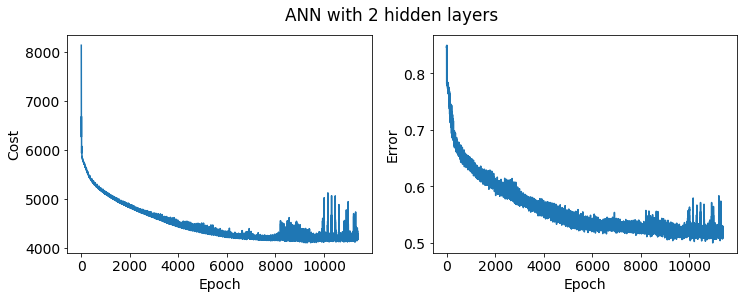

In [16]:
plt.figure(figsize=(12,4))
plt.suptitle('ANN with 2 hidden layers')
plt.subplot(121)
plt.plot(costs_2)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(errors_2)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [17]:
Y_pred2 = session2.run(Y_hat, feed_dict={X: X_test})

In [18]:
def plot_a_grid(X, Y, Y_pred, sent_dict, d): 
    # make a grid of faces with d rows and columns
    # shows the labels and the predicted ones (green if correct and red if wrong)
    N = len(X)
    plt.figure(figsize=(2.5*d, 2.5*d))
    for i in range(1, d+1):
        for j in range(1, d+1):
            n = np.random.randint(N)
            X_im = 1- X[n,].reshape(im_size,im_size)
            truth = sent_dict[Y[n]]
            pred = sent_dict[Y_pred[n]]
            index = j + (i-1) * d
            plt.subplot(d, d, index)
            plt.imshow(X_im, cmap='Greys')
            color = 'green' if Y[n] == Y_pred[n] else 'red'
            plt.text(-1,-3,truth)
            plt.text(27,-3,pred, color=color)
            plt.xticks([])
            plt.yticks([])
    plt.show()

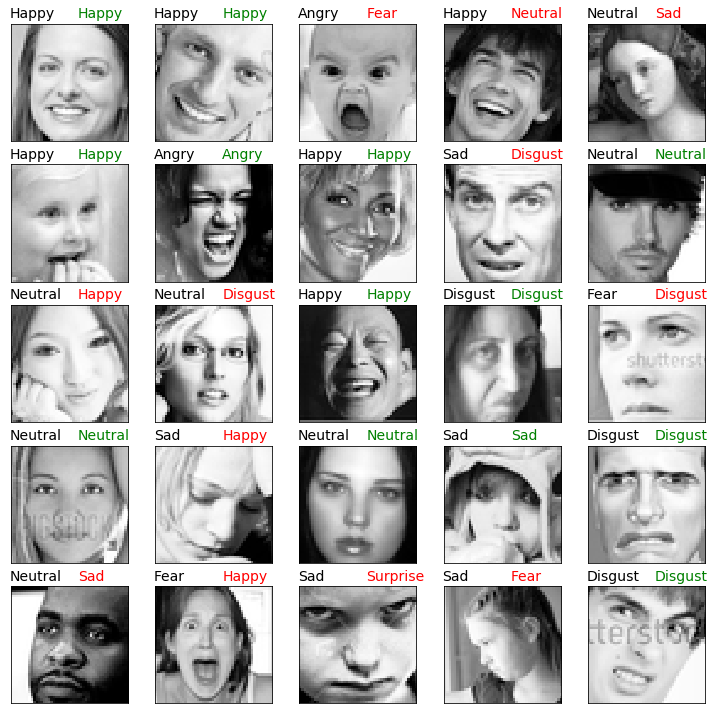

In [36]:
plot_a_grid(X_test, Y_test, Y_pred2, sent_dict, 5)

In [20]:
cm2 = confusion_matrix(Y_test, Y_pred2)

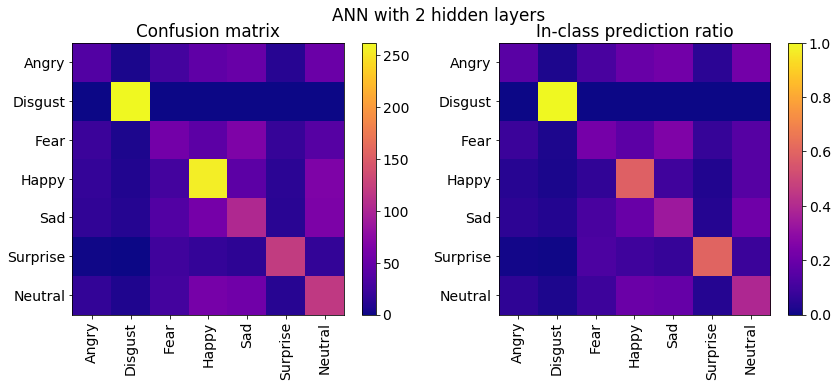

In [42]:
plt.figure(figsize=(14,5))
plt.suptitle('ANN with 2 hidden layers')
plt.subplot(121)
plt.imshow(cm2, cmap='plasma')
plt.colorbar()
plt.title('Confusion matrix')
plt.xticks(list(sent_dict.keys()), list(sent_dict.values()), rotation = 90)
plt.yticks(list(sent_dict.keys()), list(sent_dict.values()))
plt.subplot(122)
plt.imshow((cm2.T/np.sum(cm2,axis=1)).T, cmap='plasma')
plt.colorbar()
plt.title('In-class prediction ratio')
plt.xticks(list(sent_dict.keys()), list(sent_dict.values()), rotation = 90)
plt.yticks(list(sent_dict.keys()), list(sent_dict.values()))
plt.show()

#### ANN with 4 hidden layers but the same total number of neurons

In [22]:
full_iter = 200 # number of iterations over the entire data while training
eta = 0.00005 #learning rate
alpha = 0.01 # regularization
bat = 500 # batch size

In [23]:
# network size and structure
M1 = 25
M2 = 25
M3 = 25
M4 = 25
K = len(set(Ydat)) # = 7
N, D = X_train.shape # D = 48*48

n_bat = N // bat # number of batches

In [24]:
# weight initial values
W1_0 = np.random.randn(D, M1) / np.sqrt(D)
b1_0 = np.zeros(M1)
W2_0 = np.random.randn(M1, M2) / np.sqrt(M1)
b2_0 = np.zeros(M2)
W3_0 = np.random.randn(M2, M3) / np.sqrt(M2)
b3_0 = np.zeros(M3)
W4_0 = np.random.randn(M3, M4) / np.sqrt(M3)
b4_0 = np.zeros(M4)
W5_0 = np.random.randn(M4, K) / np.sqrt(M4)
b5_0 = np.zeros(K)

In [25]:
# Network weights and variables
X = tf.placeholder(tf.float32, shape = (None, D), name = 'X')
T = tf.placeholder(tf.float32, shape = (None, K), name = 'T') # one hot encoded
W1 = tf.Variable(W1_0.astype(np.float32))
b1 = tf.Variable(b1_0.astype(np.float32))
W2 = tf.Variable(W2_0.astype(np.float32))
b2 = tf.Variable(b2_0.astype(np.float32))
W3 = tf.Variable(W3_0.astype(np.float32))
b3 = tf.Variable(b3_0.astype(np.float32))
W4 = tf.Variable(W4_0.astype(np.float32))
b4 = tf.Variable(b4_0.astype(np.float32))
W5 = tf.Variable(W5_0.astype(np.float32))
b5 = tf.Variable(b5_0.astype(np.float32))

In [26]:
# (notation: H = activation(Z))
H1 = tf.nn.relu(tf.matmul(X,W1) + b1)
H2 = tf.nn.relu(tf.matmul(H1,W2) + b2)
H3 = tf.nn.relu(tf.matmul(H2,W3) + b3)
H4 = tf.nn.relu(tf.matmul(H3,W4) + b4)
Z5 = tf.matmul(H4,W5) + b5 
H5 = tf.nn.softmax(Z5)
Y_hat = tf.argmax(Z5, axis=1) #prediction

In [27]:
# cost with regularization
cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=T, logits= Z5)) + alpha*( tf.reduce_sum(W1*W1) + tf.reduce_sum(b1*b1) + tf.reduce_sum(W2*W2) + tf.reduce_sum(b2*b2) + tf.reduce_sum(W3*W3) + tf.reduce_sum(b3*b3) + tf.reduce_sum(W4*W4) + tf.reduce_sum(b4*b4) + tf.reduce_sum(W5*W5) + tf.reduce_sum(b5*b5) )

In [28]:
train_op = tf.train.RMSPropOptimizer(learning_rate=eta, momentum=0.9, decay=0.99).minimize(cost)

In [29]:
init = tf.global_variables_initializer()

In [30]:
costs_4 = []
errors_4 = []

session4 = tf.Session() 
session4.run(init)    
for i in range(full_iter):
    for j in range(n_bat):
        Xbat = X_train[j*bat:(j+1)*bat,]
        Tbat = T_train[j*bat:(j+1)*bat,]
            
        session4.run(train_op, feed_dict={X: Xbat, T: Tbat})
        test_cost = session4.run(cost, feed_dict={X: X_test, T: T_test})
        Y_pred = session4.run(Y_hat, feed_dict={X: X_test})
        err = 1 - classification_rate(Y_pred, Y_test)
        costs_4.append(test_cost)
        errors_4.append(err)

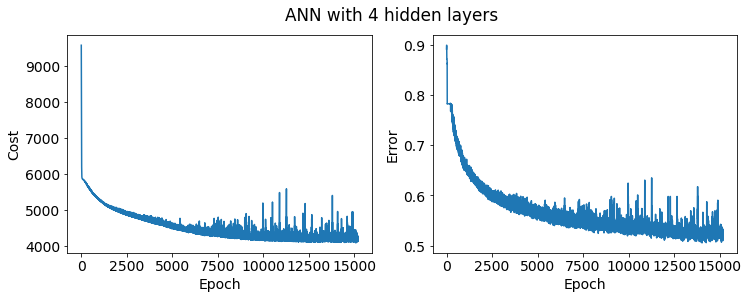

In [31]:
plt.figure(figsize=(12,4))
plt.suptitle('ANN with 4 hidden layers')
plt.subplot(121)
plt.plot(costs_4)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(errors_4)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

The error plot looks like it's just about to plateau at the end. Longer runs showed that the precision of the model could not be improved above ~50%. 

In [32]:
Y_pred4 = session4.run(Y_hat, feed_dict={X: X_test})

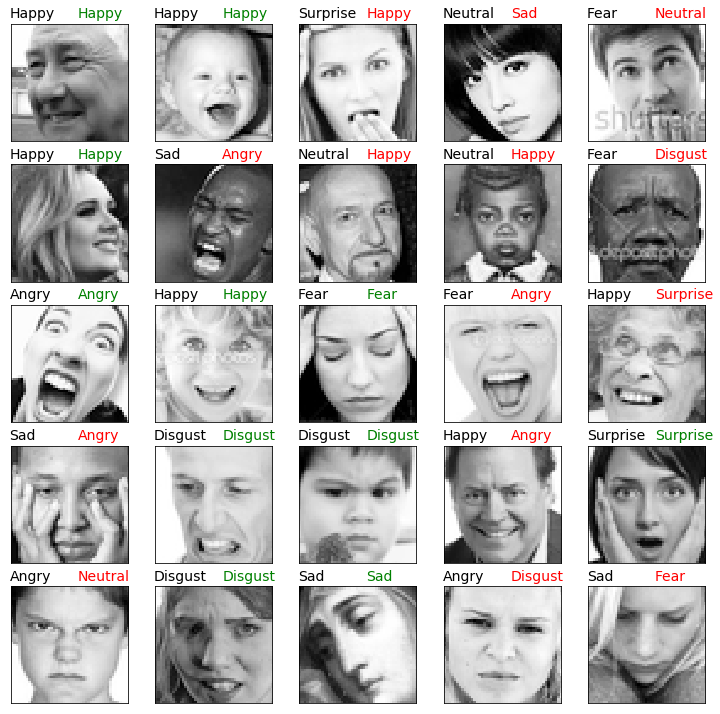

In [37]:
plot_a_grid(X_test, Y_test, Y_pred4, sent_dict, 5)

In [34]:
cm4 = confusion_matrix(Y_test, Y_pred4)

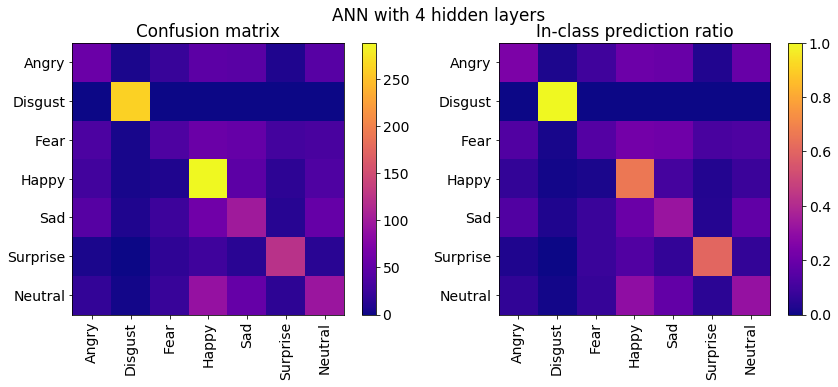

In [41]:
plt.figure(figsize=(14,5))
plt.suptitle('ANN with 4 hidden layers')
plt.subplot(121)
plt.imshow(cm4, cmap='plasma')
plt.colorbar()
plt.title('Confusion matrix')
plt.xticks(list(sent_dict.keys()), list(sent_dict.values()), rotation = 90)
plt.yticks(list(sent_dict.keys()), list(sent_dict.values()))
plt.subplot(122)
plt.imshow((cm4.T/np.sum(cm4,axis=1)).T, cmap='plasma')
plt.colorbar()
plt.title('In-class prediction ratio')
plt.xticks(list(sent_dict.keys()), list(sent_dict.values()), rotation = 90)
plt.yticks(list(sent_dict.keys()), list(sent_dict.values()))
plt.show()

##### Adding a couple of hidden layers did not seem to improve the model. 'Disgust', 'happy', and 'surprise' are predicted best by both models, but 'fear', 'angry', and 'sad' are harder to distinguish. 'Neutral' is also mistaken with 'happy' a lot. 

##### It is known that Convolutional NN could do much better in image recognition. 